<a href="https://colab.research.google.com/github/NeoBeaver/hello-world/blob/master/MyStockAnalysisToolboxV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Run this cell first (contains all the source code)
# For division
from __future__ import division

# For data manipulation
import pandas as pd
import numpy as np
import datetime as dt

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# Provide stock analysis tools
#
class StockAnalysis:

    # Params
    # symbol_list:      list of position symbols
    # start_date:  Start date of the historical data
    # end_date:  End date of the historivcal data
    #
    def __init__(self, symbol_list, start_date, end_date):

        # Put symbol_list into a member variable
        self.symbol_list = symbol_list

        # Set up Start and End times for fetching historic data
        self.start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
        self.end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")

        # determine the calculcation mode for mean, total return, etc. using nature calendar days
        self.mode = self._get_mode(self.start_date, self.end_date)

        # Grab all the closing prices for the stock list into one DataFrame
        # The price is dividend adjusted price
        # Call datareader directly, and fill all the 'NA's with the nearest value
        self.df_price = DataReader(symbol_list, 'yahoo', self.start_date, self.end_date)['Adj Close']

        # get the row size
        self.effective_days = self.df_price.shape[0]

        # add three columns 'year', 'month' and 'week' for grouping later
        self.df_price['year'] = self.df_price.index.year
        self.df_price['month'] = self.df_price.index.month
        self.df_price['week'] = self.df_price.index.week

        # Various mean annual returns
        ## Total Return in the period [start_date, end_date]
        ## CAGR annual return, this is the default one for calculate Sharpe ratio
        ## Avg. annual return
        ## Sharpe Ratio
        self.df_stats = pd.DataFrame(index=symbol_list)
        

        # Calculate various return values
        self._get_mean_return()
        # Calculate covariance/correlation matrices
        self._get_covariance()

    # Display the prices
    def plot_price(self):
        df_price_1 = (
          self.df_price[self.symbol_list]
          .fillna(method='bfill') # backward fill, for company having no price until IPO date
          .fillna(method='ffill') # forward fill, for company's stock stopped trading since certain day, eg. acquired or bankrupted
        )
        ax = df_price_1.plot(figsize=(10,8))
        ax.set_ylabel('Price')
        plt.grid()
        plt.show()
    # Plot the return curve normalized to the start_date
    def plot_return(self):
        df_price_1 = (
          self.df_price[self.symbol_list]
          .fillna(method='bfill') # backward fill, for company having no price until IPO date
          .fillna(method='ffill') # forward fill, for company's stock stopped trading since certain day, eg. acquired or bankrupted
        )
        # Normalizing the prices to start at 1.0 and see relative returns
        df_normalized_price = df_price_1 / df_price_1.iloc[0, :]
        # Plot
        ax = df_normalized_price.plot(figsize=(10,8))
        ax.set_ylabel('Return')
        plt.grid()
        plt.show()

    # Print the basic stats of the stocks
    def print_stats(self):
        print("\n\n---------------------Positions in Your Portfolio-----------------------------\n")
        print("Checking historical prices from {}  to {}, Effective trading days: {} \n".format(self.start_date, self.end_date, self.effective_days) )
        print("For the above period, we use {} level for mean, std and covariance calculations \n".format(self.mode) )
        df_stats_percent = pd.DataFrame(index=self.symbol_list)
        df_stats_percent['Total Return (%)'] = self.df_stats['Total Return']*100
        df_stats_percent['CAGR Return (%)'] = self.df_stats['CAGR Return']*100
        df_stats_percent['Mean Yearly Return (%)'] = self.df_stats['Mean Yearly Return']*100
        df_stats_percent['STD (%)'] = self.df_stats['STD']*100
        df_stats_percent['Sharpe Ratio'] = self.df_stats['Sharpe Ratio']
        pd.set_option('precision', 2)
        pd.set_option('display.max_columns', None)
        display(df_stats_percent)


    # Show Correlation
    def show_correlation(self):
        # Print correlation Matrix
        print("\n\nYour Positions' Correlation Matrix({} level):\n".format(self.mode) )
        pd.set_option('precision', 3)  # more precisions for correlations
        display(self.cor)

        title = "Correlation Matrix(" + self.mode + " level)"
        plt.clf()
        plt.figure(figsize=(10,8))
        sns.heatmap(self.cor,
                    vmin = -1,
                    vmax = 1,
                    xticklabels = self.cor.columns.values,
                    yticklabels = self.cor.columns.values, cmap="coolwarm")
        plt.title(title)
        plt.show()

    # Get mode of calculating mean/variance: day/week/month, based on calendar period [start_date, end_date]
    def _get_mode(self, start_date, end_date):
        my_days = (end_date - start_date).days   # calendar days
        if my_days <= 30:
            mode = "day"
        elif my_days > 30 and my_days <=90:
            mode = "week"
        else:
            mode = "month"
        return mode

    # Utility function to calculate total return percentage for a data series or a dataframe
    def _total_return(self, prices, mode):
        # drop na data first
        prices = prices.dropna()

        # for month mode:  at least 15 trading days excluding holidays+weekends
        # for year mode: at least 220 trading days
        if mode == 'week':
            minlen = 3
        elif mode == 'month':
            minlen = 10
        elif mode == 'year':
            #minlen = 220
            # To inlcude 2019 partial year data
            minlen = 80
        else:
            print("Not a supported mode period in calculating total return!!! ")
            exit(-1)

        mylen = len(prices.index)
        if mylen < minlen:  # very partial month, let's ignore this data point
            return None
        else:
            return prices.iloc[-1] / prices.iloc[0] - 1

    # get all mean returns including CAGR and avg arithmetic means
    # use either CAGR or manual input means for calculation though
    # avg. arithmetic means are for insights only at this point
    def _get_mean_return(self):

        # Calculate monthly arithmetric mean return from the
        # dividend adjusted prices
        #
        # get the row size
        rownum = self.df_price.shape[0]
        d0 = self.df_price.index[0]            # first trading date
        d1 = self.df_price.index[rownum - 1]   # last trading date
        days = (d1-d0).days              # regular calendar days including weekends and other non-trading days
        years = days/365.


        # total absolute return over period [start_date, end_date]
        df1 = self.df_price[self.symbol_list].pct_change(periods=rownum - 1)

        # get the absolute return in this period
        self.df_stats['Total Return'] = df1.iloc[rownum - 1]

        # get CAGR return
        self.df_stats['CAGR Return'] = (1 + df1.iloc[rownum - 1]) ** (1. / years) - 1

        # traditional mean yearly return
        self.df_yearly = self.df_price.groupby(['year'])[self.symbol_list].apply(self._total_return, 'year')
        self.df_yearly = self.df_yearly.dropna()

        self.df_stats['Mean Yearly Return'] = self.df_yearly.mean()
    
    def _get_covariance(self):
        # Calculate covariance matrix of all positions
        mode = self.mode
        if mode == 'day':    # use daily data for covariance
            tech_rets = self.df_price.pct_change()
            df1 =  tech_rets[self.symbol_list]
        elif mode == 'week':
            df1 = self.df_price.groupby(['week'])[self.symbol_list].apply(self._total_return, mode)
        else:  # use monthly level when we have enough data
            # get total return % per year for the stocks
            # assign results to a new dataframe
            df1 = self.df_price.groupby(['year', 'month'])[self.symbol_list].apply(self._total_return, mode)

        # Position variance list based on daily returns
        self.df_stats['STD'] = df1.std()
        # Calculate Sharpe Ratio
        if mode == 'month':
          # We think 'month' is just right for calculating Sharpe Ratio
          # However, Sharpe Ratio is usually reported on annual basis.
          # Need to annualize the STD by multiply sqrt(12), assuming normal distribution
          self.df_stats['Sharpe Ratio'] = self.df_stats['CAGR Return'] / (self.df_stats['STD']*np.sqrt(12))
        else:
          self.df_stats['Sharpe Ratio'] = 0.0
          print("Warning: Not long enough period to calculate Sharpe Ratio")

        # covariance matrix
        self.corrmatx =  df1.cov()

        # correlation matrix
        self.cor = df1.corr()

        

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Study1: ETFs Correlation
I'm primarily interested in largest ETFs covering major asset classes:
### Equity
#### US Large Cap Growth
**SPY** - track S&P 500 index (similar: IVV, VOO, they are all at similar prices \$250)
#### US Total Stock Market
**VTI** - includes US companies of all sizes, although the allocations to mid caps and small caps are not significant. (price \$122, similar: ITOT \$56)
#### Nasdaq 100
**QQQ** - heavy on the mega-cap tech companies, FAANG take up 45%, while only ~20% for SPY, expense ratio is relatively high - 0.2%
#### Emerging Market
**EEM** - large cap companies mostly in China, South Korea, BABA, TCEHY, TSM, Samsung, 中国建行，etc but also South Africa, India.
### Bond Market
**BND** - entire investment grade bond market - T-Bills, corporates, MBS, and agency bonds. Weighted toward short term. 

**TLT** - 20-year Treasury Bond. long-term
### Speciaty ETFs
**XLE** - Energy Industry
**XLB** - Material Industry





In [0]:
SA = StockAnalysis(['SPY', 'VTI', 'QQQ', 'EEM', 'BND', 'XLE'], '2007-05-01', '2020-03-29')

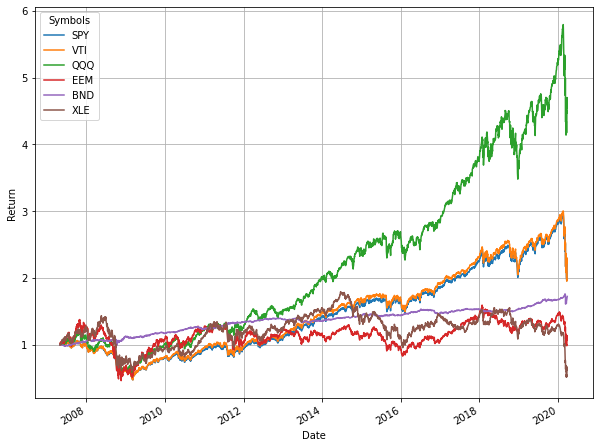

In [0]:
SA.plot_return()

In [0]:
SA.print_stats()



---------------------Positions in Your Portfolio-----------------------------

Checking historical prices from 2007-05-01 00:00:00  to 2020-03-29 00:00:00, Effective trading days: 3251 

For the above period, we use month level for mean, std and covariance calculations 



,Total Return (%),CAGR Return (%),Mean Yearly Return (%),STD (%),Sharpe Ratio
SPY,122.59,6.39,9.18,4.64,0.40
VTI,122.60,6.39,9.44,4.80,0.38
QQQ,354.18,12.43,15.02,5.16,0.70
EEM,7.31,0.55,6.00,6.68,0.02
BND,72.42,4.31,4.13,0.97,1.28
XLE,-37.68,-3.60,2.73,7.10,-0.15




Your Positions' Correlation Matrix(month level):



Symbols,SPY,VTI,QQQ,EEM,BND,XLE
Symbols,,,,,,
SPY,1.000,0.997,0.922,0.829,0.076,0.773
VTI,0.997,1.000,0.921,0.831,0.069,0.780
QQQ,0.922,0.921,1.000,0.779,0.049,0.653
EEM,0.829,0.831,0.779,1.000,0.192,0.716
BND,0.076,0.069,0.049,0.192,1.000,-0.058
XLE,0.773,0.780,0.653,0.716,-0.058,1.000


<Figure size 432x288 with 0 Axes>

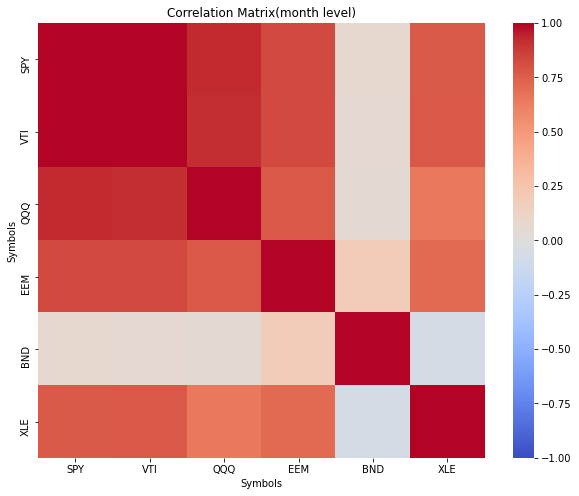

In [0]:
SA.show_correlation()

## Some Conclusions
#### 1. SPY and VTI are almost the same, although VTI also includes some mid-cap and small-cap. The deciding factor will be the price and expense ratio.
#### 2. SPY and QQQ are highly correlated, but the return can differ quite a bit. Likely due to the network effect of FAANG.
#### 3. EEM is also considered highly correlated with US market, but much lower return in the past 13 years, while suffers from the largest volotility here.
#### 4. BND is stable in general, uncorrelated with equity assets. 
#### 5. XLE is among the largest volitility, least performing in the past 13 years.  

## Study2: Individual Stock vs. ETF

### I'm trying to answer this question:
Is it still beneficial to buy individual stocks instead of ETFs?

### QQQ vs its Top-4 Holdings
https://etfdb.com/etf/QQQ/#holdings

In [0]:
SA = StockAnalysis(['QQQ', 'MSFT', 'AAPL', 'AMZN', 'GOOG'], '2007-05-01', '2020-03-29')

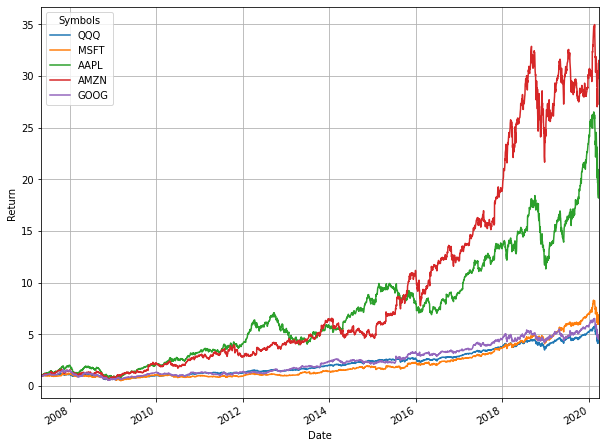

In [0]:
SA.plot_return()

In [0]:
SA.print_stats()



---------------------Positions in Your Portfolio-----------------------------

Checking historical prices from 2007-05-01 00:00:00  to 2020-03-29 00:00:00, Effective trading days: 3251 

For the above period, we use month level for mean, std and covariance calculations 



,Total Return (%),CAGR Return (%),Mean Yearly Return (%),STD (%),Sharpe Ratio
QQQ,354.18,12.43,15.02,5.16,0.70
MSFT,560.49,15.74,18.65,6.88,0.66
AAPL,1908.45,26.15,35.90,8.74,0.86
AMZN,2962.70,30.34,37.68,8.82,0.99
GOOG,375.43,12.83,19.24,7.60,0.49


### EEM vs its Top-4 holdings
https://etfdb.com/etf/EEM/#holdings

In [0]:
SA = StockAnalysis(['EEM', 'BABA', 'TCEHY', 'TSM', 'SSNLF'], '2014-09-20', '2020-03-29')  # Choose this time range because BABA IPO'ed on 2014-09-18

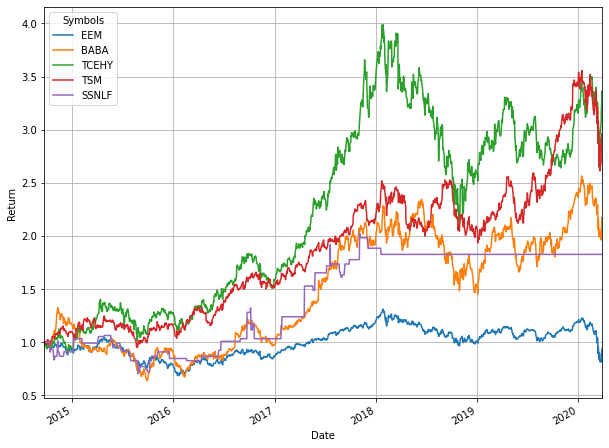

In [0]:
SA.plot_return()

In [0]:
SA.print_stats()



---------------------Positions in Your Portfolio-----------------------------

Checking historical prices from 2014-09-20 00:00:00  to 2020-03-29 00:00:00, Effective trading days: 1389 

For the above period, we use month level for mean, std and covariance calculations 



,Total Return (%),CAGR Return (%),Mean Yearly Return (%),STD (%),Sharpe Ratio
EEM,-11.60,-2.21,7.12,4.82,-0.13
BABA,109.80,14.38,23.47,10.18,0.41
TCEHY,219.22,23.42,34.20,6.93,0.98
TSM,179.18,20.46,28.00,6.24,0.95
SSNLF,82.64,11.54,18.89,7.64,0.44




Your Positions' Correlation Matrix(month level):



Symbols,EEM,BABA,TCEHY,TSM,SSNLF
Symbols,,,,,
EEM,1.000,0.600,0.601,0.740,0.245
BABA,0.600,1.000,0.533,0.494,0.247
TCEHY,0.601,0.533,1.000,0.469,0.384
TSM,0.740,0.494,0.469,1.000,0.115
SSNLF,0.245,0.247,0.384,0.115,1.000


<Figure size 432x288 with 0 Axes>

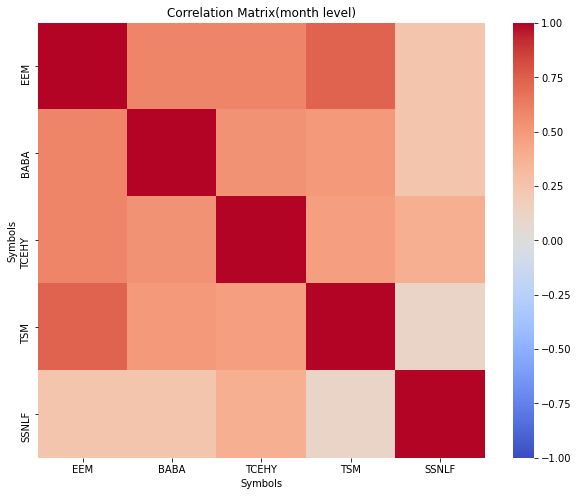

In [0]:
SA.show_correlation()